In [1]:
#Needed Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import os
import sys

from tqdm import tqdm

import json
from pathlib import Path

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
tqdm.pandas()

sns.set(font_scale = 1.25)
sns.set_style("whitegrid")
# pd.set_option('display.max_rows', None)

SOURCES = ['Apache', 'Hyperledger', 'IntelDAOS', 
           'JFrog', 'Jira', 'JiraEcosystem', 
           'MariaDB', 'Mindville', 'MongoDB', 
           'Qt', 'RedHat', 'Sakai', 
           'SecondLife', 'Sonatype', 'Spring']

In [3]:
def load_data(source):
    #Loading Issues
    filename = '../data/crawl/issues_'+source.lower()+'.csv'
    issues = pd.read_csv(filename, encoding="UTF-8", low_memory=False, sep=';', index_col=['issue_id'])
    
    #Loading Links
    filename = '../data/crawl/clean_links_'+source.lower()+'.csv'
    links = pd.read_csv(filename, encoding="UTF-8", low_memory=False, index_col=0, sep=';')
    
    return issues, links

In [4]:
link_dict = {}
issue_dict = {}

for s in SOURCES:
    print(s.upper())
    issues, links = load_data(s)
    link_dict[s] = links
    issue_dict[s] = issues

APACHE
HYPERLEDGER
INTELDAOS
JFROG
JIRA
JIRAECOSYSTEM
MARIADB
MINDVILLE
MONGODB
QT
REDHAT
SAKAI
SECONDLIFE
SONATYPE
SPRING


In [38]:
s = 'Spring'
links = link_dict[s]

links[links['linktype']=='Subtask']

,name,linktype,issue_id_1,issue_id_2,issues
53,XD-3654_XD-3655,Subtask,XD-3654,XD-3655,"['XD-3654', 'XD-3655']"
73,XD-3624_XD-3660,Subtask,XD-3624,XD-3660,"['XD-3624', 'XD-3660']"
74,XD-3624_XD-3674,Subtask,XD-3624,XD-3674,"['XD-3624', 'XD-3674']"
138,XD-3563_XD-3564,Subtask,XD-3563,XD-3564,"['XD-3563', 'XD-3564']"
166,XD-2747_XD-2763,Subtask,XD-2747,XD-2763,"['XD-2747', 'XD-2763']"
...,...,...,...,...,...
14435,AMQP-418_AMQP-640,Subtask,AMQP-418,AMQP-640,"['AMQP-418', 'AMQP-640']"
14436,AMQP-418_AMQP-641,Subtask,AMQP-418,AMQP-641,"['AMQP-418', 'AMQP-641']"
14437,AMQP-418_AMQP-642,Subtask,AMQP-418,AMQP-642,"['AMQP-418', 'AMQP-642']"
14438,AMQP-418_AMQP-650,Subtask,AMQP-418,AMQP-650,"['AMQP-418', 'AMQP-650']"


In [39]:
links = link_dict[s]

links[links['linktype']=='Epic-Relation']

,name,linktype,issue_id_1,issue_id_2,issues
4,XD-3742_XD-1607,Epic-Relation,XD-3742,XD-1607,"['XD-1607', 'XD-3742']"
6,XD-3735_XD-2053,Epic-Relation,XD-3735,XD-2053,"['XD-2053', 'XD-3735']"
7,XD-3733_XD-696,Epic-Relation,XD-3733,XD-696,"['XD-3733', 'XD-696']"
8,XD-3714_XD-2629,Epic-Relation,XD-3714,XD-2629,"['XD-2629', 'XD-3714']"
11,XD-3708_XD-3477,Epic-Relation,XD-3708,XD-3477,"['XD-3477', 'XD-3708']"
...,...,...,...,...,...
13414,DATAJDBC-386_DATAJDBC-452,Epic-Relation,DATAJDBC-386,DATAJDBC-452,"['DATAJDBC-386', 'DATAJDBC-452']"
13432,DATAJDBC-318_DATAJDBC-452,Epic-Relation,DATAJDBC-318,DATAJDBC-452,"['DATAJDBC-318', 'DATAJDBC-452']"
14185,BATCH-2105_BATCH-2103,Epic-Relation,BATCH-2105,BATCH-2103,"['BATCH-2103', 'BATCH-2105']"
14186,BATCH-2104_BATCH-2103,Epic-Relation,BATCH-2104,BATCH-2103,"['BATCH-2103', 'BATCH-2104']"


In [37]:
def print_linktypes(SOURCE):
    
    issues = issue_dict[SOURCE]
    links = link_dict[SOURCE]
        
    num_links = len(links)
    num_issues = len(issues)
    
    issue_set = set(issues.index.values)
    link_set = set(links['issue_id_1']).union(set(links['issue_id_2']))

    projects = issues[['projectid']]

    temp = links.join(projects, how = 'inner', on='issue_id_1')
    temp = temp.join(projects, how = 'inner', on='issue_id_2', lsuffix='_1', rsuffix='_2')

    temp['sameproject'] = (temp["projectid_1"]==temp["projectid_2"])

    blub = temp.linktype.value_counts().rename_axis('linktype').reset_index(name='counts')
    try:
        same_ratio = round(temp['sameproject'].value_counts().loc[True]/len(temp)*100, 2)
    except:
        same_ratio = 0
    try:
        cross_ratio = round(temp['sameproject'].value_counts().loc[False]/len(temp)*100, 2)
    except:
        cross_ratio = 0

    blub = links.linktype.value_counts().rename_axis('linktype').reset_index(name='counts')
    blub['source'] = SOURCE
    blub['percentages'] = blub['counts'].apply(lambda x: round(x/len(links),3)*100)
    blub['sameproject'] = 0
    blub['crossproject'] = 0
    for i in temp.linktype.value_counts().index:
        link_temp = temp[temp['linktype'] == i]
        try:
            same_ratio_temp = round(link_temp['sameproject'].value_counts().loc[True]/len(link_temp)*100, 2)
        except:
            same_ratio_temp = 0
        try:
            cross_ratio_temp = round(link_temp['sameproject'].value_counts().loc[False]/len(link_temp)*100, 2)
        except:
            cross_ratio_temp = 0
        link_index = blub.index[blub['linktype']==i]
        link_index = list(link_index)
        blub['sameproject'].iloc[link_index[0]] = same_ratio_temp
        blub['crossproject'].iloc[link_index[0]] = cross_ratio_temp
        
    return num_issues, num_links, len(links.linktype.unique()), round(len(link_set)/len(issue_set), 3), len(link_set), same_ratio, cross_ratio, blub

In [38]:
overview = pd.DataFrame(columns = ['Source', '#Issues', '#Links', '#Linktypes', '%IssuesWithLinks', '#LinkedIssues', "%SameProject", "%CrossProject"])
link_dist = pd.DataFrame(columns=['source', 'linktype', 'counts'])
j = 0
for s in SOURCES:
    i, l, ltu, pi, li, sr, cr, blub = print_linktypes(s)
    overview.loc[j] = [s, i, l, ltu, pi, li, sr, cr]
    
    j+=1
    
    frames = [link_dist, blub]
    #concatenate dataframes
    link_dist = pd.concat(frames, sort=False)

In [39]:
overview

,Source,#Issues,#Links,#Linktypes,%IssuesWithLinks,#LinkedIssues,%SameProject,%CrossProject
0,Apache,970929,242823,21,0.283,275112,94.69,5.31
1,Hyperledger,27914,16225,8,0.551,15374,95.38,4.62
2,IntelDAOS,5557,3222,10,0.555,3083,100.00,0.00
3,JFrog,14769,3206,11,0.298,4400,91.77,8.23
4,Jira,265343,98122,19,0.477,126484,56.15,43.85
5,JiraEcosystem,40602,10911,18,0.328,13298,93.24,6.76
6,MariaDB,31229,14618,8,0.445,13895,97.46,2.54
7,Mindville,2134,44,4,0.040,85,95.45,4.55
8,MongoDB,90629,37545,13,0.426,38604,88.66,11.34
9,Qt,140237,35855,8,0.289,40532,92.85,7.15


In [40]:
print(overview.sum())
print(overview.mean())

Source              ApacheHyperledgerIntelDAOSJFrogJiraJiraEcosyst...
#Issues                                                       2103146
#Links                                                         607208
#Linktypes                                                        171
%IssuesWithLinks                                                5.232
#LinkedIssues                                                  698790
%SameProject                                                  1366.92
%CrossProject                                                  133.08
dtype: object
#Issues             140209.733333
#Links               40480.533333
#Linktypes              11.400000
%IssuesWithLinks         0.348800
#LinkedIssues        46586.000000
%SameProject            91.128000
%CrossProject            8.872000
dtype: float64


In [102]:
link_dist[link_dist["linktype"]=='Backports']

,source,linktype,counts,percentages,sameproject,crossproject
9,MongoDB,Backports,66,0.2,95.45,4.55


In [12]:
print(link_dist.linktype.unique())
print(len(link_dist.linktype.unique()))

['Subtask' 'Reference' 'Duplicate' 'Blocker' 'dependent' 'Epic-Relation'
 'Incorporates' 'Regression' 'Cloners' 'Required' 'Container' 'Related'
 'Supercedes' 'Problem/Incident' 'Child-Issue' 'Blocked' 'Completes'
 'Dependent' 'Dependency' 'Parent Feature' 'Testing' 'Relates' 'Blocks'
 'Issue split' 'Git Code Review' 'Gantt End to Start' 'Gantt End to End'
 'Implement' 'Gantt Start to Start' 'Relationship' 'Trigger'
 'Contains(WBSGantt)' 'Finish-to-Finish link (WBSGantt)' 'Part' 'Detail'
 'Cause' 'Derived' 'Supersession' 'Relate' 'Bonfire Testing' 'Split'
 'Resolve' 'Depends' 'Follows' 'Bonfire testing' 'Epic' 'Preceded By'
 'PartOf' 'Documented' 'Gantt Dependency' 'Backports' 'Tested'
 'Replacement' 'Work Breakdown' 'Test' 'Superset' 'Sequence' 'Causality'
 'Cloners (old)' 'Documentation' 'Parent-Relation'
 'multi-level hierarchy [GANTT]' 'Gantt: finish-start'
 'Gantt: finish-finish' 'Gantt: start-finish' 'finish-start [GANTT]'
 'finish-finish [GANTT]' 'Depend' 'Incorporate' 'Caused' 

In [103]:
type_dict={'Backports': 'Backport', 
           
    'Blocked': 'Block',
    'Blocker': 'Block',
    'Blocks': 'Block',
           
    'Bonfire Testing': 'Bonfire Testing', 
    'Bonfire testing': 'Bonfire Testing', 
    'Git Code Review': 'Bonfire Testing', 
    'Testing': 'Bonfire Testing',
           
    'Causality': 'Cause', 
    'Cause': 'Cause',
    'Caused': 'Cause', 
    'Problem/Incident': 'Cause',
           
    'Child-Issue': 'Parent-Child', 
    'Parent Feature': 'Parent-Child',
    'Parent/Child': 'Parent-Child',
    'multi-level hierarchy [GANTT]': 'Parent-Child',
    'Parent-Relation': 'Parent-Child',
           
    'Cloners': 'Clone', 
    'Cloners (old)': 'Clone', 
           
    'Collection': 'Incorporate', 
    'Container': 'Incorporate',
    'Contains(WBSGantt)': 'Incorporate', 
    'Incorporate': 'Incorporate', 
    'Incorporates': 'Incorporate', 
    'Part': 'Incorporate',
    'PartOf': 'Incorporate',
    'Superset': 'Incorporate', 
           
    'Completes': 'Fix', 
    'Fixes': 'Fix',
    'Resolve': 'Fix',
           
    'Depend': 'Depend', 
    'Dependency': 'Depend', 
    'Dependent': 'Depend', 
    'Depends': 'Depend', 
    'Gantt Dependency': 'Depend',
    'dependent': 'Depend',
           
    'Derived': 'Derive',
           
    'Detail': 'Detail', 
           
    'Documentation': 'Documented',
    'Documented': 'Documented',
    
    'Duplicate': 'Duplicate',
           
    'Epic': 'Epic', 
    'Epic-Relation': 'Epic',
    
    'Finish-to-Finish link (WBSGantt)': 'finish-finish', 
    'Gantt End to End': 'finish-finish', 
    'Gantt: finish-finish': 'finish-finish',
    'finish-finish [GANTT]': 'finish-finish', 
    
    'Gantt End to Start': 'finish-start', 
    'Gantt: finish-start': 'finish-start',
    'finish-start [GANTT]': 'finish-start',

    'Gantt Start to Start': 'start-start', 
    
    'Gantt: start-finish': 'start-finish',
    
    'Follows': 'Follow', 
    'Sequence': 'Follow', 
    
    'Implement': 'Implement', 
    'Implements': 'Implement', 
    
    'Issue split': 'Split',
    'Split': 'Split',
    'Work Breakdown': 'Split',
    
    'Preceded By': 'Precede', 
    
    'Reference': 'Relate',
    'Relate': 'Relate',
    'Related': 'Relate', 
    'Relates': 'Relate',
    'Relationship': 'Relate',
    
    'Regression': 'Breaks',
    
    'Replacement': 'Replace',
    
    'Required': 'Require',
    
    'Supercedes': 'Supercede',
    'Supersede': 'Supercede',
    'Supersession': 'Supercede', 
    
    'Test': 'Test', 
    'Tested': 'Test',
    
    'Trigger': 'Trigger',
          
    'Subtask': 'Subtask'}

In [104]:
def print_cleaned_linktypes(SOURCE):  
    
    issues = issue_dict[SOURCE]
    links = link_dict[SOURCE]
    
    issue_set = set(issues.index.values)
    link_set = set(links['issue_id_1']).union(set(links['issue_id_2']))
    
    links['mappedtype'] = links['linktype'].map(type_dict)
            
    projects = issues[['projectid']]

    temp = links.join(projects, how = 'inner', on='issue_id_1')
    temp = temp.join(projects, how = 'inner', on='issue_id_2', lsuffix='_1', rsuffix='_2')

    temp['sameproject'] = (temp["projectid_1"]==temp["projectid_2"])

    blub = links.mappedtype.value_counts().rename_axis('mappedtype').reset_index(name='counts')
    blub['source'] = SOURCE
    blub['percentageOfLinks'] = blub['counts'].apply(lambda x: round(x/len(links),10)*100)
    blub['percentagesOfIssues'] = 0
    blub['sameproject'] = 0
    blub['crossproject'] = 0
    for i in range(len(blub)):
        mappedType = blub['mappedtype'].iloc[i]
        link_temp = temp[temp['mappedtype'] == mappedType]
        lt_set = set(link_temp['issue_id_1']).union(set(link_temp['issue_id_2']))
        blub['percentagesOfIssues'].iloc[i] = round(len(lt_set)/len(issue_set),10)*100
        
        try:
            same_ratio_temp = round(link_temp['sameproject'].value_counts().loc[True]/len(link_temp)*100, 2)
        except:
            same_ratio_temp = 0
        try:
            cross_ratio_temp = round(link_temp['sameproject'].value_counts().loc[False]/len(link_temp)*100, 2)
        except:
            cross_ratio_temp = 0
            
        blub['sameproject'].iloc[i] = same_ratio_temp
        blub['crossproject'].iloc[i] = cross_ratio_temp
        
    return len(links.mappedtype.unique()), blub

In [105]:
overview_cl = pd.DataFrame(columns=['Source', '#Linktypes'])
link_dist_cl = pd.DataFrame(columns=['source', 'mappedtype', 'counts'])
j = 0
for s in SOURCES:
    ltu, blub = print_cleaned_linktypes(s)
    overview_cl.loc[j] = [s, ltu]
    
    j+=1
    
    frames = [link_dist_cl, blub]
    #concatenate dataframes
    link_dist_cl = pd.concat(frames, sort=False)

In [106]:
len(link_dist_cl.mappedtype.unique())

30

In [107]:
link_dist_cl['mappedtype'].value_counts().sort_index(ascending=True)

Backport            1
Block               8
Bonfire Testing     6
Breaks              2
Cause               7
Clone              12
Depend             10
Derive              1
Detail              1
Documented          2
Duplicate          14
Epic                9
Fix                 3
Follow              3
Implement           2
Incorporate         8
Parent-Child        3
Precede             1
Relate             15
Replace             1
Require             1
Split               8
Subtask            14
Supercede           4
Test                2
Trigger             1
finish-finish       4
finish-start        3
start-finish        1
start-start         2
Name: mappedtype, dtype: int64

In [108]:
#used in more than 7 projects
common_lt = (link_dist_cl.mappedtype.value_counts()>=15*0.45).rename_axis('mappedtype').reset_index(name='valid')
common_lt_set = common_lt[common_lt['valid']==True]['mappedtype'].values

In [109]:
commontypes = link_dist_cl[link_dist_cl['mappedtype'].isin(common_lt_set)]

In [110]:
commontypes.groupby(['mappedtype']).agg({'counts': ['sum'], 'percentageOfLinks': ['mean'], 'sameproject': ['mean'], 'crossproject': ['mean']})

,counts,percentageOfLinks,sameproject,crossproject
,sum,mean,mean,mean
mappedtype,,,,
Block,36293,7.300065,87.726250,12.273750
Cause,9317,3.176648,86.905714,13.094286
Clone,25217,4.867385,85.521667,14.478333
Depend,30367,8.238249,85.053000,14.947000
Duplicate,70419,13.279347,96.872857,3.127143
Epic,32766,19.005375,98.704444,1.295556
Incorporate,24805,4.456619,94.161250,5.838750
Relate,218833,35.274554,88.752000,11.248000


In [114]:
#easier to copy for Latex
pivot = pd.pivot_table(commontypes, values='percentageOfLinks', index=['source'],
                    columns=['mappedtype'], aggfunc=np.sum)
pivot_new = pd.DataFrame()
pivot_new = pivot[common_lt_set]
pivot_new.round(1)
pivot_new['Coverage'] = pivot_new.sum(axis=1)

print("-----Averages-----")
print(pivot_new.mean())
print("-----Standard Deviation-----")
print(pivot_new.std())

pivot_new['Relate'] = pivot_new['Relate'].apply(lambda x: str(round(x,2))+'%')
pivot_new['Subtask'] = pivot_new['Subtask'].apply(lambda x: str(round(x,2))+'%')
pivot_new['Duplicate'] = pivot_new['Duplicate'].apply(lambda x: str(round(x,2))+'%')
pivot_new['Clone'] = pivot_new['Clone'].apply(lambda x: str(round(x,2))+'%')
pivot_new['Depend'] = pivot_new['Depend'].apply(lambda x: str(round(x,2))+'%')
pivot_new['Epic'] = pivot_new['Epic'].apply(lambda x: str(round(x,2))+'%')
pivot_new['Split'] = pivot_new['Split'].apply(lambda x: str(round(x,2))+'%')
pivot_new['Block'] = pivot_new['Block'].apply(lambda x: str(round(x,2))+'%')
pivot_new['Incorporate'] = pivot_new['Incorporate'].apply(lambda x: str(round(x,2))+'%')
pivot_new['Cause'] = pivot_new['Cause'].apply(lambda x: str(round(x,2))+'%')
pivot_new['Coverage'] = pivot_new['Coverage'].apply(lambda x: str(round(x,2))+'%')

print(pivot_new.round(2).to_latex())

-----Averages-----
mappedtype
Relate         35.274554
Subtask        20.626340
Duplicate      13.279347
Clone           4.867385
Depend          8.238249
Epic           19.005375
Split           1.112916
Block           7.300065
Incorporate     4.456619
Cause           3.176648
Coverage       96.055385
dtype: float64
-----Standard Deviation-----
mappedtype
Relate         14.804435
Subtask        14.109976
Duplicate       9.226013
Clone           5.531317
Depend          6.412486
Epic           21.194965
Split           2.149492
Block           4.887113
Incorporate     3.008811
Cause           1.882438
Coverage        3.639915
dtype: float64
\begin{tabular}{llllllllllll}
\toprule
mappedtype &  Relate & Subtask & Duplicate &   Clone &  Depend &    Epic &  Split &   Block & Incorporate &  Cause & Coverage \\
source        &         &         &           &         &         &         &        &         &             &        &          \\
\midrule
Apache        &  28.53\% &   32.5\% &    

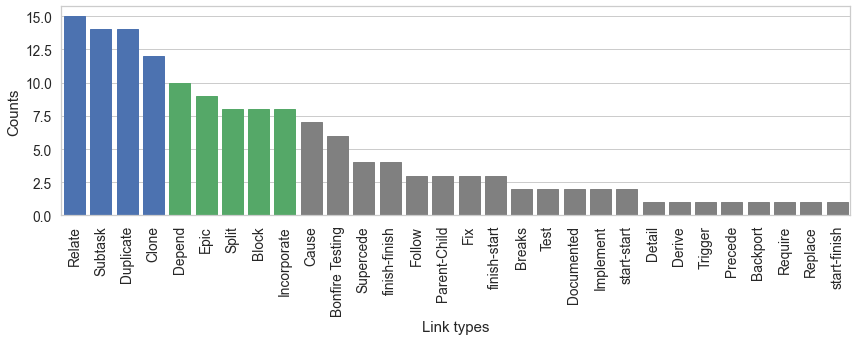

In [116]:
link_dist_count = link_dist_cl['mappedtype'].value_counts()

fig = plt.gcf()
fig.set_size_inches(12, 5)

plt.xticks(rotation=90)
ax = sns.barplot(link_dist_count.index, link_dist_count.values)

for bar in ax.patches:
    if bar.get_height() >= 15*0.75:
        bar.set_color('b')  
    elif bar.get_height() > 15*0.5:
        bar.set_color('g') 
    else:
        bar.set_color('grey')

ax.set(xlabel ="Link types", ylabel = "Counts")

plt.tight_layout()
        
plt.savefig('pictures/link_dist_cleaned.png', dpi = 300)

In [117]:
tidy2 = link_dist_cl.melt(id_vars='mappedtype').rename(columns=str.title)
tidy = tidy2[(tidy2['Variable']=='percentageOfLinks')]

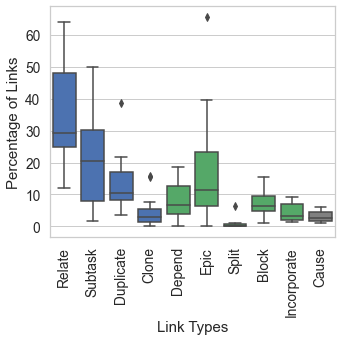

In [118]:
fig = plt.gcf()
fig.set_size_inches(5, 5)

plt.xticks(rotation=90)
ax = sns.boxplot(x='Mappedtype', y='Value', data=tidy, order=common_lt_set)

for i in [0,1,2,3]:
    mybox = ax.artists[i]
    mybox.set_facecolor('b')
    
for i in [4,5,6,7,8]:
    mybox = ax.artists[i]
    mybox.set_facecolor('g')
    
for i in [9]:
    mybox = ax.artists[i]
    mybox.set_facecolor('grey')


ax.set(xlabel ="Link Types", ylabel = "Percentage of Links")

plt.tight_layout()
        
plt.savefig('pictures/link_usage_cleaned.png', dpi = 300)


In [119]:
tidy3 = link_dist_cl.melt(id_vars='mappedtype').rename(columns=str.title)
tidy4 = tidy3[(tidy3['Variable']=='percentagesOfIssues')]

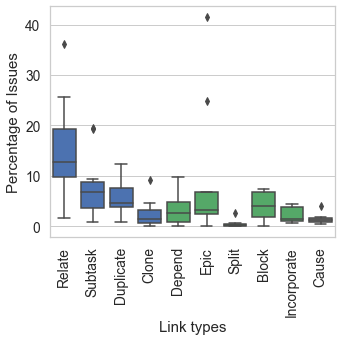

In [120]:
fig = plt.gcf()
fig.set_size_inches(5, 5)

plt.xticks(rotation=90)
ax = sns.boxplot(x='Mappedtype', y='Value', data=tidy4, order=common_lt_set)

for i in [0,1,2,3]:
    mybox = ax.artists[i]
    mybox.set_facecolor('b')
    
for i in [4,5,6,7,8]:
    mybox = ax.artists[i]
    mybox.set_facecolor('g')
    
for i in [9]:
    mybox = ax.artists[i]
    mybox.set_facecolor('grey')


ax.set(xlabel ="Link types", ylabel = "Percentage of Issues")

plt.tight_layout()
        
plt.savefig('pictures/link_usage_issues_cleaned.png', dpi = 300)


In [121]:
pivot_extra = pivot.copy()
pivot_extra['Other'] = 100-pivot.sum(axis=1)

In [122]:
pivot_extra

mappedtype,Block,Cause,Clone,Depend,Duplicate,Epic,Incorporate,Relate,Split,Subtask,Other
source,,,,,,,,,,,
Apache,6.163337,1.027086,1.664587,5.239207,10.241204,4.943107,4.144583,28.532717,NaN,32.498157,5.546015e+00
Hyperledger,8.265023,NaN,2.902928,NaN,3.907550,39.685670,NaN,17.121726,0.456086,27.617874,4.314330e-02
IntelDAOS,6.548728,NaN,4.500310,NaN,3.631285,65.735568,NaN,12.135320,NaN,5.803849,1.644941e+00
JFrog,NaN,NaN,0.623830,7.985028,19.931379,NaN,1.341235,27.230193,NaN,36.306925,6.581410e+00
Jira,0.968182,1.787571,2.761868,0.051976,21.758627,NaN,2.486700,63.949981,0.171215,2.485681,3.578199e+00
JiraEcosystem,5.856475,3.748511,1.768857,1.127303,15.773073,23.270094,1.842178,23.279259,1.200623,20.364769,1.768857e+00
MariaDB,12.990833,5.965248,NaN,NaN,9.399371,6.444110,7.894377,51.060337,0.150499,6.095225,1.000001e-08
Mindville,2.272727,NaN,15.909091,NaN,38.636364,NaN,NaN,43.181818,NaN,NaN,0.000000e+00
MongoDB,NaN,1.712612,0.157145,18.508457,17.440405,6.264483,NaN,49.125050,0.354242,1.632707,4.804901e+00


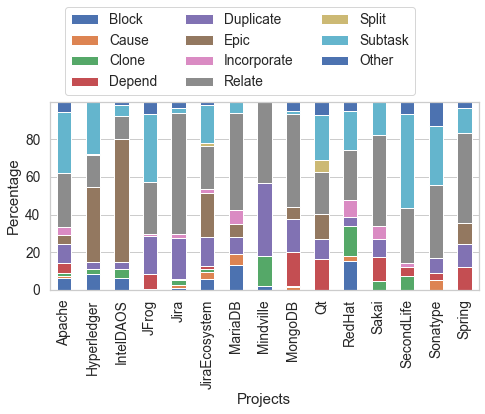

In [123]:
f, (ax) = plt.subplots(1, 1, figsize=(7, 6), sharex=True)

fig = plt.gcf()
# fig.set_size_inches(10, 10)

ax = pivot_extra.plot(kind='bar', stacked=True, mark_right = True, ax=ax)
ax.set(xlabel ="Projects", ylabel = "Percentage")

plt.legend(bbox_to_anchor=(0.02, 1, 1, 0), ncol=3)

plt.tight_layout()

ax.figure.savefig("pictures/link_type_distribution_cleaned.png")